In [1]:
import torch
import numpy as np
from torch import nn,optim
import time
import matplotlib.pylab as plt
import torchvision
%matplotlib inline

In [2]:
def get_data_ch7():
    data=np.genfromtxt(r'F:\study\ml\DataSet\airfoil_self_noise\airfoil_self_noise.dat',
                      delimiter='\t')
    data=(data-data.mean(axis=0)) / data.std(axis=0)
    features=torch.tensor(data[:1500,:-1],dtype=torch.float32)
    labels=torch.tensor(data[:1500,-1],dtype=torch.float32)
    return features,labels

In [3]:
features,labels=get_data_ch7()
features.shape

torch.Size([1500, 5])

In [4]:
def init_adadelta_states():
    s_w,s_b=torch.zeros(features.shape[1],1,dtype=torch.float32), \
    torch.zeros(1,dtype=torch.float32)
    delta_w,delta_b=torch.zeros(features.shape[1],1,dtype=torch.float32), \
    torch.zeros(1,dtype=torch.float32)
    return((s_w,delta_w),(s_b,delta_b))
    

In [5]:
def adadelta(params,states,hyperparams):
    rho,eps=hyperparams['rho'],1e-5
    for p,(s,d) in zip(params,states):
        s[:]=rho*s+(1-rho)*(p.grad.data*p.grad.data)
        g=torch.sqrt((d+eps)/(s+eps)) * p.grad.data
        p.data -=g
        d[:]=rho*d+(1-rho)*g*g

In [6]:
def linreg(x,w,b):
    return torch.mm(x,w)+b
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.shape))**2

In [7]:
def train_ch7(optimizer_fun,
              states,
              hyperparams,
              features,
              labels,
              batch_size=10,
              num_epochs=2):

    net, loss = linreg, squared_loss
    w = nn.Parameter(
        torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)),
                     dtype=torch.float32,
                     requires_grad=True))
    b = nn.Parameter(
        torch.tensor(np.zeros(1), dtype=torch.float32, requires_grad=True))
    
    def eval_loss():
        return loss(net(features,w,b),labels).mean().item() /2
    
    ls=[eval_loss()]
    
    data_iter=torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(features,labels),batch_size=batch_size,
    shuffle=True)
    
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=loss(net(X,w,b),y).mean() /2
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            optimizer_fun([w,b],states,hyperparams)
            if (batch_i+1) * batch_size % 100  ==0:
                ls.append(eval_loss())
    print('loss : %f, %f sec per epoch' % (ls[-1],time.time()-start))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs')
    plt.ylabel('loss')

In [ ]:
plt.xl

loss : 0.244402, 0.082005 sec per epoch


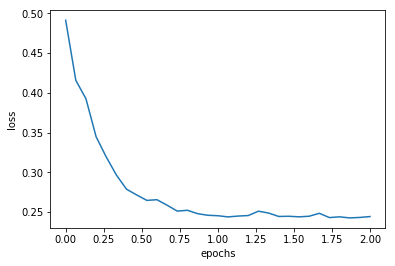

In [8]:
train_ch7(adadelta,init_adadelta_states(),{'rho':0.9},features,labels)